In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
%cd ..
import pickle
with open('Dataset/Bergman_cyclization.pkl', 'rb') as file:
    data_list = pickle.load(file)

/home/zengyun1/App/miniconda3/envs/gnn/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/zengyun1/gnn/2/TMP_NN


In [5]:
from torch.utils.data import TensorDataset, DataLoader,random_split

def get_datalist(data_list,atom_list):
    data_size = len(data_list)
    atom_num = len(atom_list)
    x3d_total = torch.empty(data_size, atom_num, 8, 8, 8)  
    x2d_total = torch.empty(data_size, atom_num, 10, 20)
    x1d_total = torch.empty(data_size, atom_num, 22)
    x0d_total = torch.empty(data_size, 13)  
    y_total = torch.empty(data_size, 1)  
    for idx, G in enumerate(data_list):
        x3d_total[idx] = G.x3d[atom_list, :, :, :]
        x2d_total[idx] = G.x2d[atom_list, :, :]
        x1d_total[idx] = G.x[atom_list, :22]
        x0d_total[idx] = G.global_features

        
        y_total[idx] = G.y

    dataset = TensorDataset(x3d_total, x2d_total, x1d_total, x0d_total, y_total)
    return dataset

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Cov3D(nn.Module):
    def __init__(self, num_atoms=10):
        super(Cov3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(32 * num_atoms, 256)  
        self.fc2 = nn.Linear(256,128)  

    def forward(self, x):
        batch_size = x.size(0)
        num_atoms = x.size(1)
        x = x.view(batch_size * num_atoms, 1, 8, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(batch_size, num_atoms, -1)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))


        return x  
    
class Cov2D(nn.Module):
    def __init__(self, num_atoms=10):
        super(Cov2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.fc1 = nn.Linear(64 * 5 * 10 * num_atoms, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        batch_size = x.size(0)
        num_atoms = x.size(1)
        x = x.view(batch_size * num_atoms, 1, 10, 20)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x

class Cov1D(nn.Module):
    def __init__(self):
        super(Cov1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=32, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
        self.fc1 = nn.Linear(64 * 10, 256)  
        self.fc2 = nn.Linear(256, 128)  

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x  


In [53]:

class WeightedConcat(nn.Module):
    def __init__(self, num_inputs):
        super(WeightedConcat, self).__init__()
        self.weights = nn.Parameter(torch.ones(num_inputs))

    def forward(self, *inputs):
        weighted_inputs = [w * inp for w, inp in zip(self.weights, inputs)]
        return torch.cat(weighted_inputs, dim=1)

class FusionModelWithAttention(nn.Module):
    def __init__(self):
        super(FusionModelWithAttention, self).__init__()
        self.cov3d = Cov3D()
        self.cov2d = Cov2D()
        self.cov1d = Cov1D()

        self.weighted_concat = WeightedConcat(num_inputs=3)
        dropout_rate=0.5

        self.layers = nn.Sequential(
            nn.Linear(128*3 , 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 64),
            nn.Dropout(p=dropout_rate),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x3d, x2d, x1d):
        out3d = self.cov3d(x3d)
        out2d = self.cov2d(x2d)
        out1d = self.cov1d(x1d)
        
        # attn_3d_1d = self.cross_attention_3d_1d(out3d, out1d)
        # print(attn_3d_1d.shape)
        # print( out3d.shape,out2d.shape, out1d.shape)
        x = self.weighted_concat( out3d,out2d, out1d)
        x = self.layers(x)
        return x
        




In [40]:
atom_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
atom_num = len(atom_list)
dataset = get_datalist(data_list, atom_list)
train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size

torch.manual_seed(2025)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

criterion = nn.MSELoss()



In [56]:
model = FusionModelWithAttention().to(device)

criterion = nn.MSELoss()  # Replace with your loss function if necessary
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    model.train()
    running_loss = 0.0
    for x3d, x2d, x1d, x0d, targets in train_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(x3d, x2d, x1d)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_dataloader)
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            outputs = model(x3d, x2d, x1d)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_test_loss:.4f}")


Epoch [100/100], Loss: 6.9859: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


In [31]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x3d, x2d, x1d, x0d, targets in test_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        outputs = model(x3d, x2d, x1d)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 6.1497


In [22]:
best_val_loss=9999
LR = 0.01
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)  
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  
num_epochs = 1000

lr_list = []  
pbar = tqdm(range(num_epochs))

train_loss_list = []
val_loss_list = []
total_actuals = []
total_predictions = []
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    model.train()  
    running_loss = 0.0
    for x3d, x2d, x1d, x0d, targets in train_dataloader:
        x3d, x2d, x1d, x0d, targets = x3d.to(device), x2d.to(device), x1d.to(device), x0d.to(device), targets.to(device)
        
        optimizer.zero_grad()  
        outputs = model(x3d, x2d, x1d)  
        loss = criterion(outputs, targets)  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    
    scheduler.step()  
    current_lr = optimizer.state_dict()['param_groups'][0]['lr']
    lr_list.append(current_lr)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in test_dataloader:
            x3d, x2d, x1d, x0d, targets = x3d.to(device), x2d.to(device), x1d.to(device), x0d.to(device), targets.to(device)
            outputs = model(x3d, x2d, x1d)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    pbar.set_postfix(dict(Training=f"{avg_loss:.1f}", Validation=f"{avg_val_loss:.1f}"))

    train_loss_list.append(avg_loss)
    val_loss_list.append(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch}: Validation loss improved to {best_val_loss:.4f}. Model saved.")

    actuals = []
    predictions = []
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in train_dataloader:
            x3d, x2d, x1d, x0d, targets = x3d.to(device), x2d.to(device), x1d.to(device), x0d.to(device), targets.to(device)
            outputs = model(x3d, x2d, x1d)
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())

    actuals = np.array(actuals)
    predictions = np.array(predictions)
    total_actuals.append(actuals)
    total_predictions.append(predictions)

  0%|          | 1/1000 [00:00<05:59,  2.78it/s, Training=199.0, Validation=49.9]

Epoch 0: Validation loss improved to 49.8832. Model saved.


  0%|          | 2/1000 [00:00<05:12,  3.19it/s, Training=133.0, Validation=26.5]

Epoch 1: Validation loss improved to 26.4930. Model saved.


  0%|          | 5/1000 [00:01<04:38,  3.58it/s, Training=93.9, Validation=21.8] 

Epoch 4: Validation loss improved to 21.8272. Model saved.


  1%|          | 8/1000 [00:02<04:28,  3.70it/s, Training=92.3, Validation=16.7]  

Epoch 7: Validation loss improved to 16.7124. Model saved.


  1%|          | 12/1000 [00:03<04:25,  3.72it/s, Training=80.2, Validation=14.2]

Epoch 11: Validation loss improved to 14.1848. Model saved.


  1%|▏         | 13/1000 [00:03<04:25,  3.72it/s, Training=77.4, Validation=13.5]

Epoch 12: Validation loss improved to 13.4874. Model saved.


  1%|▏         | 14/1000 [00:03<04:24,  3.73it/s, Training=69.4, Validation=12.6]

Epoch 13: Validation loss improved to 12.6325. Model saved.


  2%|▏         | 18/1000 [00:04<04:22,  3.75it/s, Training=74.6, Validation=12.5]

Epoch 17: Validation loss improved to 12.4764. Model saved.


  2%|▏         | 20/1000 [00:05<04:26,  3.67it/s, Training=66.3, Validation=10.6]

Epoch 19: Validation loss improved to 10.6356. Model saved.


  3%|▎         | 27/1000 [00:07<04:20,  3.73it/s, Training=65.6, Validation=9.7] 

Epoch 26: Validation loss improved to 9.6871. Model saved.


  3%|▎         | 31/1000 [00:08<04:24,  3.67it/s, Training=57.0, Validation=8.7] 

Epoch 30: Validation loss improved to 8.6958. Model saved.


  4%|▎         | 36/1000 [00:09<04:20,  3.70it/s, Training=58.2, Validation=8.6] 

Epoch 35: Validation loss improved to 8.6390. Model saved.


  4%|▍         | 40/1000 [00:10<04:19,  3.70it/s, Training=59.0, Validation=8.6] 

Epoch 39: Validation loss improved to 8.5984. Model saved.


 65%|██████▍   | 649/1000 [03:11<01:43,  3.38it/s, Training=56.4, Validation=10.1]


KeyboardInterrupt: 

In [60]:

class Cov1D(nn.Module):
    def __init__(self):
        super(Cov1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=22, out_channels=32, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)

        self.fc1 = nn.Linear(64*10, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.8)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)
        return output
    

class Cov3D(nn.Module):
    def __init__(self, num_atoms=10):
        super(Cov3D, self).__init__()

        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.AdaptiveMaxPool3d(1)

        self.fc1 = nn.Linear(32 * num_atoms, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.8)

    def forward(self, x):
        batch_size = x.size(0)
        num_atoms = x.size(1)

        x = x.view(batch_size * num_atoms, 1, 8, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(batch_size, num_atoms, -1)
        x = x.view(batch_size, -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x
class Cov1D_3D(nn.Module):
    def __init__(self):
        super(Cov1D_3D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1)
        self.fc1 = nn.Linear(288, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.8)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)
        return output
class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim, hidden_dim):
        super(CrossAttention, self).__init__()
        self.query_projection = nn.Linear(query_dim, hidden_dim)
        self.key_projection = nn.Linear(key_dim, hidden_dim)
        self.value_projection = nn.Linear(value_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
    def forward(self, query, key, value):
        query_projected = self.layer_norm(self.query_projection(query))
        key_projected = self.layer_norm(self.key_projection(key))
        value_projected = self.layer_norm(self.value_projection(value))

        # Calculate attention scores
        attention_scores = torch.matmul(query_projected, key_projected.transpose(-2, -1))
        attention_scores = attention_scores / (self.hidden_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply the attention weights to the values
        attention_output = torch.matmul(attention_weights, value_projected)
        return attention_output
    
class FusionModelWithAttention(nn.Module):
    def __init__(self):
        super(FusionModelWithAttention, self).__init__()
        self.cov3d = Cov3D()
        self.cov1d = Cov1D()
        self.cov1d_3d = Cov1D_3D()
        self.attention1d_3d = CrossAttention(query_dim=22, key_dim=512, value_dim=512, hidden_dim=128)
        self.fc_fusion = nn.Linear(3, 1)
    def forward(self, x3d,x2d, x1d):
        batch_size, num_atoms, d, h, w = x3d.size()

        x3d_reshape = x3d.view(batch_size,num_atoms, -1)
        x1d_3d = self.attention1d_3d(x1d, x3d_reshape, x3d_reshape)
        # print(x1d_3d.shape)

        # x1d_3d, _ = self.lstm_rnn1(x1d_3d)
        # x1d_3d = x1d_3d[:, -1, :]  


        out3d = self.cov3d(x3d)
        out1d = self.cov1d(x1d)
        out1d_3d = self.cov1d_3d(x1d_3d)

        x = torch.cat([out3d,  out1d,out1d_3d], dim=1)
        x = self.fc_fusion(x)
        return x
        




In [9]:
class PiecewiseWeightedMSELoss(nn.Module):
    def __init__(self, lower_threshold=30, upper_threshold=40, lower_weight=2.0, upper_weight=2.0):
        super(PiecewiseWeightedMSELoss, self).__init__()
        self.lower_threshold = lower_threshold
        self.upper_threshold = upper_threshold
        self.lower_weight = lower_weight
        self.upper_weight = upper_weight

    def forward(self, predictions, targets):
        weights = torch.ones_like(targets)
        weights[targets < self.lower_threshold] = self.lower_weight
        weights[targets > self.upper_threshold] = self.upper_weight
        return torch.mean(weights * (predictions - targets) ** 2)


In [99]:
model = FusionModelWithAttention().to(device)

# criterion = nn.MSELoss() 
criterion = PiecewiseWeightedMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    model.train()
    running_loss1 = 0.0
    for x3d, x2d, x1d, x0d, targets in train_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(x3d, x2d, x1d)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss1 += loss.item()
    
    running_loss2 = 0.0
    for x3d, x2d, x1d, x0d, targets  in train_dataloader:  
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(x3d[:,rearrang_list,:,:,:],x2d[:,rearrang_list,:,:],x1d[:,rearrang_list,:])
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss2 += loss.item()

    avg_loss = (running_loss1+running_loss2) / (2 * len(train_dataloader))



    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            outputs = model(x3d, x2d, x1d)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)

    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.2f},Test:{avg_test_loss:.2f}")


#目标是小于3

Epoch [1000/1000], Loss: 3.51,Test:8.25: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]


In [62]:
import matplotlib.pyplot as plt
def model_Performance(dataloader,model):
    model.eval() 
    actuals = []
    predictions = []
    with torch.no_grad():
        for x3d,x2d,x1d,x0d, targets  in dataloader:
            x3d,x2d,x1d,x0d, targets = x3d.to(device),x2d.to(device),x1d.to(device),x0d.to(device),targets.to(device)
            outputs = model(x3d,x2d,x1d)
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    actuals = np.array(actuals)
    predictions = np.array(predictions)
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=4)  
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title('Actual vs. Prediction')
    plt.show()
    



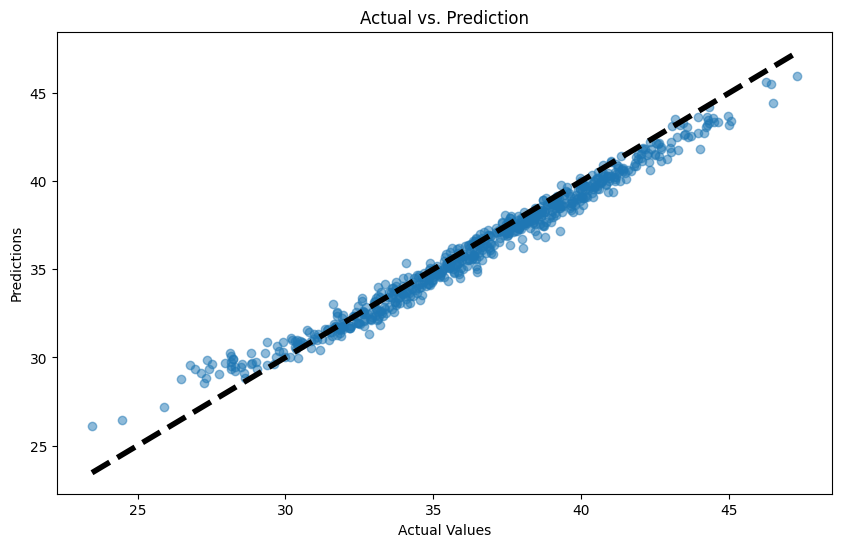

In [66]:
model_Performance(train_dataloader,model)

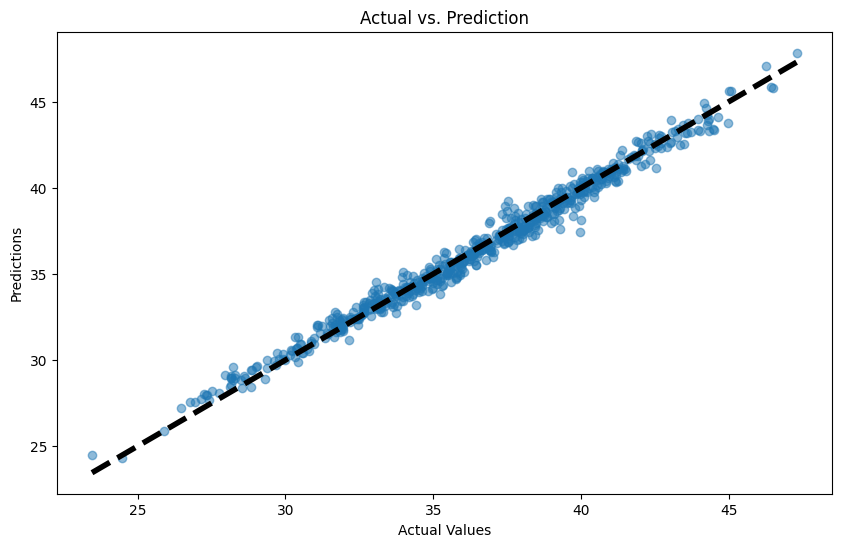

In [81]:
model_Performance(train_dataloader,model)

In [10]:
rearrang_list=[5,4,3,2,1,0,9,8,7,6]

In [98]:
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in train_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            outputs = model(x3d[:,rearrang_list,:,:,:],x2d[:,rearrang_list,:,:],x1d[:,rearrang_list,:])
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
avg_test_loss


102.24480724334717

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()

        # Define the Cov1D sub-network
        self.conv1_1d = nn.Conv1d(in_channels=22, out_channels=32, kernel_size=1)
        self.conv2_1d = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
        self.fc1_1d = nn.Linear(64 * 10, 128)
        self.fc2_1d = nn.Linear(128, 64)
        self.dropout_1d = nn.Dropout(p=0.5)

        # Define the Cov2D sub-network
        self.conv1_2d = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2_2d = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.pool_2d = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.fc1_2d = nn.Linear(64 * 5 * 10 * 10, 128)
        self.fc2_2d = nn.Linear(128, 64)
        self.dropout_2d = nn.Dropout(p=0.5)

        # Define the Cov3D sub-network
        self.conv1_3d = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2_3d = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool_3d = nn.AdaptiveAvgPool3d(1)
        self.fc1_3d = nn.Linear(32 * 10, 128)
        self.fc2_3d = nn.Linear(128, 64)
        self.dropout_3d = nn.Dropout(p=0.5)

        # Final fully connected layers to combine the outputs
        self.fc1 = nn.Linear(64 * 3, 64)  # 64 * 3 because we have 3 sub-networks each outputting 64 features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self,x3d,x2d, x1d):
        # Forward pass through Cov1D sub-network
        x1d = x1d.permute(0, 2, 1)
        x1d = F.relu(self.conv1_1d(x1d))
        x1d = F.relu(self.conv2_1d(x1d))
        x1d = x1d.view(x1d.size(0), -1)
        x1d = F.relu(self.fc1_1d(x1d))
        x1d = self.dropout_1d(x1d)
        out1d = F.relu(self.fc2_1d(x1d))

        # Forward pass through Cov2D sub-network
        batch_size = x2d.size(0)
        num_atoms = x2d.size(1)
        x2d = x2d.view(batch_size * num_atoms, 1, 10, 20)
        x2d = F.relu(self.conv1_2d(x2d))
        x2d = self.pool_2d(F.relu(self.conv2_2d(x2d)))
        x2d = x2d.view(batch_size, -1)
        x2d = F.relu(self.fc1_2d(x2d))
        x2d = self.dropout_2d(x2d)
        out2d = F.relu(self.fc2_2d(x2d))

        # Forward pass through Cov3D sub-network
        batch_size = x3d.size(0)
        num_atoms = x3d.size(1)
        x3d = x3d.view(batch_size * num_atoms, 1, 8, 8, 8)
        x3d = F.relu(self.conv1_3d(x3d))
        x3d = F.relu(self.conv2_3d(x3d))
        x3d = self.pool_3d(x3d)
        x3d = x3d.view(batch_size, num_atoms, -1)
        x3d = x3d.view(batch_size, -1)
        x3d = F.relu(self.fc1_3d(x3d))
        x3d = self.dropout_3d(x3d)
        out3d = F.relu(self.fc2_3d(x3d))

        # Concatenate the outputs
        combined = torch.cat((out1d, out2d, out3d), dim=1)

        # Forward pass through the final fully connected layers
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)

        return output


In [140]:
model = Model1().to(device)

# criterion = nn.MSELoss() 
criterion = PiecewiseWeightedMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    model.train()
    running_loss1 = 0.0
    for x3d, x2d, x1d, x0d, targets in train_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(x3d, x2d, x1d)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss1 += loss.item()
    
    running_loss2 = 0.0
    for x3d, x2d, x1d, x0d, targets  in train_dataloader:  
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(x3d[:,rearrang_list,:,:,:],x2d[:,rearrang_list,:,:],x1d[:,rearrang_list,:])
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss2 += loss.item()

    avg_loss = (running_loss1+running_loss2) / (2 * len(train_dataloader))



    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            outputs = model(x3d, x2d, x1d)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)

    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.2f},Test:{avg_test_loss:.2f}")


#目标是小于3

Epoch [1000/1000], Loss: 3.83,Test:11.33: 100%|██████████| 1000/1000 [11:53<00:00,  1.40it/s]


In [11]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),  # Map to input_dim instead of 1
            nn.Tanh(),
            nn.Linear(input_dim, input_dim)  # Keep the output dimension as input_dim
        )

    def forward(self, x):
        # Compute attention scores
        scores = self.attention(x)  # Shape: (batch_size, input_dim)
        weights = F.softmax(scores, dim=1)  # Shape: (batch_size, input_dim)

        # Apply attention weights to the input features
        output = weights * x  # Element-wise multiplication, Shape: (batch_size, input_dim)
        return output

import torch
import torch.nn as nn
import torch.nn.functional as F

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        # Define Cov1D with Batch Normalization
        self.conv1_1d = nn.Conv1d(in_channels=22, out_channels=32, kernel_size=1)
        self.bn1_1d = nn.BatchNorm1d(32)
        self.conv2_1d = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
        self.bn2_1d = nn.BatchNorm1d(64)
        self.fc1_1d = nn.Linear(64 * 10, 128)
        self.fc2_1d = nn.Linear(128, 64)
        self.dropout_1d = nn.Dropout(p=0.5)

        # Define Cov2D with Batch Normalization
        self.conv1_2d = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.bn1_2d = nn.BatchNorm2d(32)
        self.conv2_2d = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.bn2_2d = nn.BatchNorm2d(64)
        self.pool_2d = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.fc1_2d = nn.Linear(64 * 5 * 10 * 10, 128)
        self.fc2_2d = nn.Linear(128, 64)
        self.dropout_2d = nn.Dropout(p=0.5)

        # Define Cov3D with Batch Normalization
        self.conv1_3d = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1_3d = nn.BatchNorm3d(16)
        self.conv2_3d = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2_3d = nn.BatchNorm3d(32)
        self.pool_3d = nn.AdaptiveAvgPool3d(1)
        self.fc1_3d = nn.Linear(32 * 10, 128)
        self.fc2_3d = nn.Linear(128, 64)
        self.dropout_3d = nn.Dropout(p=0.5)

        # Attention Layer

        # Final fully connected layers
        self.fc1 = nn.Linear(64*3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x3d, x2d, x1d):
        # Cov1D
        x1d = x1d.permute(0, 2, 1)
        print(x1d.shape)

        x1d = F.relu(self.bn1_1d(self.conv1_1d(x1d)))
        x1d = F.relu(self.bn2_1d(self.conv2_1d(x1d)))
        x1d = x1d.view(x1d.size(0), -1)
        x1d = F.relu(self.fc1_1d(x1d))
        x1d = self.dropout_1d(x1d)
        out1d = F.relu(self.fc2_1d(x1d))

        # Cov2D
        batch_size = x2d.size(0)
        num_atoms = x2d.size(1)
        x2d = x2d.view(batch_size * num_atoms, 1, 10, 20)
        print(x2d.shape)
        x2d = F.relu(self.bn1_2d(self.conv1_2d(x2d)))
        x2d = self.pool_2d(F.relu(self.bn2_2d(self.conv2_2d(x2d))))
        x2d = x2d.view(batch_size, -1)
        x2d = F.relu(self.fc1_2d(x2d))
        x2d = self.dropout_2d(x2d)
        out2d = F.relu(self.fc2_2d(x2d))

        # Cov3D
        x3d = x3d.view(batch_size * num_atoms, 1, 8, 8, 8)
        print(x3d.shape)

        x3d = F.relu(self.bn1_3d(self.conv1_3d(x3d)))
        x3d = F.relu(self.bn2_3d(self.conv2_3d(x3d)))
        x3d = self.pool_3d(x3d)
        x3d = x3d.view(batch_size, num_atoms, -1)
        x3d = x3d.view(batch_size, -1)
        x3d = F.relu(self.fc1_3d(x3d))
        x3d = self.dropout_3d(x3d)
        out3d = F.relu(self.fc2_3d(x3d))


        combined = torch.cat((out1d, out2d, out3d), dim=1)
        # Final layers
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
model = Model2().to(device)

# criterion = nn.MSELoss() 
criterion = PiecewiseWeightedMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    model.train()
    running_loss1 = 0.0
    for x3d, x2d, x1d, x0d, targets in train_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(x3d, x2d, x1d)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss1 += loss.item()
    
    running_loss2 = 0.0
    for x3d, x2d, x1d, x0d, targets  in train_dataloader:  
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(x3d[:,rearrang_list,:,:,:],x2d[:,rearrang_list,:,:],x1d[:,rearrang_list,:])
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss2 += loss.item()

    avg_loss = (running_loss1+running_loss2) / (2 * len(train_dataloader))



    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            outputs = model(x3d, x2d, x1d)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)

    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.2f},Test:{avg_test_loss:.2f}")


#目标是小于3

In [143]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x3d, x2d, x1d, x0d, targets in test_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        outputs = model(x3d[:,rearrang_list,:,:,:],x2d[:,rearrang_list,:,:],x1d[:,rearrang_list,:])
        loss = criterion(outputs, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
avg_test_loss

8.575032954866236

# xunlian

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Cov1D(nn.Module):
    def __init__(self):
        super(Cov1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=22, out_channels=32, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)

        self.fc1 = nn.Linear(64*10, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x


class Cov2D(nn.Module):
    def __init__(self, num_atoms=10):
        super(Cov2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.fc1 = nn.Linear(64 * 5 * 10 * num_atoms, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        batch_size = x.size(0)
        num_atoms = x.size(1)
        x = x.view(batch_size * num_atoms, 1, 10, 20)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x


class Cov3D(nn.Module):
    def __init__(self, num_atoms=10):
        super(Cov3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(32 * num_atoms, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        batch_size = x.size(0)
        num_atoms = x.size(1)
        x = x.view(batch_size * num_atoms, 1, 8, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(batch_size, num_atoms, -1)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
 

        return x

class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.feature1_extractor = Cov1D()
        self.feature2_extractor = Cov2D()
        self.feature3_extractor = Cov3D()
        self.fc1 = nn.Linear(64 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x3d, x2d, x1d):
        x1d = self.feature1_extractor(x1d)
        x2d = self.feature2_extractor(x2d)
        x3d = self.feature3_extractor(x3d)
        x = torch.cat((x1d, x2d, x3d), dim=-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x




In [62]:

class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.q_linear = nn.Linear(dim, dim)
        self.k_linear = nn.Linear(dim, dim)
        self.v_linear = nn.Linear(dim, dim)
        self.out_linear = nn.Linear(dim, dim)

    def forward(self, q, k, v):
        batch_size = q.size(0)

        # Linear projections
        Q = self.q_linear(q)  # (batch_size, seq_len, dim)
        K = self.k_linear(k)
        V = self.v_linear(v)

        # Split heads
        Q = Q.view(batch_size, -1, self.num_heads, Q.size(-1) // self.num_heads).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, K.size(-1) // self.num_heads).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, V.size(-1) // self.num_heads).permute(0, 2, 1, 3)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        # Concatenate heads
        context = context.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * (Q.size(-1)))

        # Final linear layer
        out = self.out_linear(context)
        return out



In [52]:
class PiecewiseWeightedMSELoss(nn.Module):
    def __init__(self, lower_threshold=30, upper_threshold=40, lower_weight=2.0, upper_weight=2.0):
        super(PiecewiseWeightedMSELoss, self).__init__()
        self.lower_threshold = lower_threshold
        self.upper_threshold = upper_threshold
        self.lower_weight = lower_weight
        self.upper_weight = upper_weight

    def forward(self, predictions, targets):
        weights = torch.ones_like(targets)
        weights[targets < self.lower_threshold] = self.lower_weight
        weights[targets > self.upper_threshold] = self.upper_weight
        return torch.mean(weights * (predictions - targets) ** 2)


In [82]:
model = Model3().to(device)

# criterion = nn.MSELoss() 
criterion = PiecewiseWeightedMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
pbar = tqdm(range(num_epochs))
test_loss_total=[]
train_loss_total=[]

for epoch in pbar:
    model.train()
    running_loss1 = 0.0
    for x3d, x2d, x1d, x0d, targets in train_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(x3d, x2d, x1d)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss1 += loss.item()
    
    running_loss2 = 0.0
    for x3d, x2d, x1d, x0d, targets  in train_dataloader:  
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(x3d[:,rearrang_list,:,:,:],x2d[:,rearrang_list,:,:],x1d[:,rearrang_list,:])
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss2 += loss.item()

    avg_loss = (running_loss1+running_loss2) / (2 * len(train_dataloader))



    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            outputs = model(x3d, x2d, x1d)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)

    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.2f},Test:{avg_test_loss:.2f}")

    test_loss_total.append(avg_test_loss)
    train_loss_total.append(avg_loss)

print(min(test_loss_total))
#目标是小于3

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1000/1000], Loss: 2.40,Test:7.45: 100%|██████████| 1000/1000 [11:21<00:00,  1.47it/s]

6.755525957454335


In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Cov1D(nn.Module):
    def __init__(self):
        super(Cov1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=22, out_channels=32, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)

        self.fc1 = nn.Linear(64*10, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x


class Cov2D(nn.Module):
    def __init__(self, num_atoms=10):
        super(Cov2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.fc1 = nn.Linear(64 * 5 * 10 * num_atoms, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        batch_size = x.size(0)
        num_atoms = x.size(1)
        x = x.view(batch_size * num_atoms, 1, 10, 20)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x


class Cov3D(nn.Module):
    def __init__(self, num_atoms=10):
        super(Cov3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(32 * num_atoms, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        batch_size = x.size(0)
        num_atoms = x.size(1)
        x = x.view(batch_size * num_atoms, 1, 8, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(batch_size, num_atoms, -1)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
 
        return x
class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim, hidden_dim):
        super(CrossAttention, self).__init__()
        self.query_projection = nn.Linear(query_dim, hidden_dim)
        self.key_projection = nn.Linear(key_dim, hidden_dim)
        self.value_projection = nn.Linear(value_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
    def forward(self, query, key, value):
        query_projected = self.layer_norm(self.query_projection(query))
        key_projected = self.layer_norm(self.key_projection(key))
        value_projected = self.layer_norm(self.value_projection(value))

        # Calculate attention scores
        attention_scores = torch.matmul(query_projected, key_projected.transpose(-2, -1))
        attention_scores = attention_scores / (self.hidden_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply the attention weights to the values
        attention_output = torch.matmul(attention_weights, value_projected)
        return attention_output
    
class Cov1D_2(nn.Module):
    def __init__(self):
        super(Cov1D_2, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)

        self.fc1 = nn.Linear(64*10, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x


class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.feature1_extractor = Cov1D()
        self.feature2_extractor = Cov2D()
        self.feature3_extractor = Cov3D()
        self.cross = Cov1D_2()
        self.fc1 = nn.Linear(64*5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.attention3d_2d = CrossAttention(query_dim=512, key_dim=200, value_dim=200, hidden_dim=64)
        self.attention1d_2d = CrossAttention(query_dim=22, key_dim=200, value_dim=200, hidden_dim=64)


    def forward(self, x3d, x2d, x1d):


        batch_size, num_atoms, d, h, w = x3d.size()
        
        x3d_reshape = x3d.view(batch_size,num_atoms, -1)
        x2d_reshape = x2d.view(batch_size, num_atoms, -1)
        x3d_2d = self.attention3d_2d(x3d_reshape, x2d_reshape, x2d_reshape)
        x1d_2d = self.attention1d_2d(x1d, x2d_reshape, x2d_reshape)
        x3d_2d = self.cross(x3d_2d)

        x1d_2d = self.cross(x1d_2d)
        x1d = self.feature1_extractor(x1d)
        x2d = self.feature2_extractor(x2d)
        x3d = self.feature3_extractor(x3d)


        x = torch.cat((x1d, x2d, x3d,x1d_2d,x3d_2d), dim=-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x




In [108]:
model = Model4().to(device)

# criterion = nn.MSELoss() 
criterion = PiecewiseWeightedMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
pbar = tqdm(range(num_epochs))
test_loss_total=[]
train_loss_total=[]

for epoch in pbar:
    model.train()
    running_loss1 = 0.0
    for x3d, x2d, x1d, x0d, targets in train_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(x3d, x2d, x1d)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss1 += loss.item()
    
    running_loss2 = 0.0
    for x3d, x2d, x1d, x0d, targets  in train_dataloader:  
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(x3d[:,rearrang_list,:,:,:],x2d[:,rearrang_list,:,:],x1d[:,rearrang_list,:])
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss2 += loss.item()

    avg_loss = (running_loss1+running_loss2) / (2 * len(train_dataloader))



    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            outputs = model(x3d, x2d, x1d)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)

    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.2f},Test:{avg_test_loss:.2f}")

    test_loss_total.append(avg_test_loss)
    train_loss_total.append(avg_loss)

print(min(test_loss_total))
#目标是小于3

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1000/1000], Loss: 2.48,Test:12.57: 100%|██████████| 1000/1000 [13:50<00:00,  1.20it/s]

8.991721456701105


In [86]:
print(min(test_loss_total))


6.755525957454335
